# FBA and pFBA Simulations

This notebook performs flux balance analysis (FBA) and parsimonious FBA for R. opacus in glucose and phenol growth conditions and creates plots to compare the results with experimental data.

### Methods: 
<ol>
<li>Calculate FBA and pFBA growth rates for each of the experimental conditions</li>
<li>Plot growth rates in comparison to experimental data</li>
<li>Compare phenol 13CMFA fluxes to FBA and pFBA predictions: Scatter plots and flux maps</li>
<li>Compare glucose 13CMFA fluxes to FBA and pFBA predictions: Scatter plots and flux maps</li>
</ol>

#### The data uses the following mapping as introduced in Notebook E:

Yoneda:

    WT 1.5g/L Phenol, 1.0g/L ammonium sulfate (WT-R) ->WT-HN-HP
    Evol33 1.5g/L Phenol, 1.0g/L ammonium sulfate (EVOL33-R) ->EVOL33-HN-HP
    Evol40 1.5g/L Phenol, 1.0g/L ammonium sulfate (EVOL40-R) -> EVOL40-HN-HP
    WT 1.0g/L Glucose, 1.0g/L ammonium sulfate (WT-G) -> WT-HN-G
    Evol33 1.0g/L Glucose, 1.0g/L ammonium sulfate (EVOL33-G) -> EVOL33-HN-G
    Evol40 1.0g/L Glucose, 1.0g/L ammonium sulfate (EVOL40-G) -> EVOL40-HN-G
    WT 1.0g/L Glucose, 0.05g/L ammonium sulfate (WT-G-N) ->WT-LN-G
    Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate (EVOL33-G-N) ->EVOL33-LN-G
    Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate (EVOL40-G-N) ->EVOL40-LN-G

Henson:

    WT 0.5g/L Phenol (WT-P-R) ->WT-P
    PVHG6 0.5g/L Phenol (PVHG6-P-R) ->PVHG-P


### Imports

In [44]:
import pandas as pd
import numpy as np
import cobra
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import scipy
from scipy.stats import linregress

### Load data from consumption and growth rate notebook (notebook E)

In [15]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data_new.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000
EVOL33-HN-G,0.031149,0.763357,0.040805,0.000000,0.000000,0.000000
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279


### Load model

In [16]:
model = cobra.io.read_sbml_model("../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml")
model

Name,ropacus_annotated_curated
Memory address,0x07f4c27f8dc90
Number of metabolites,1583
Number of reactions,2385
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


#### **Calculate growth rate predictions via FBA and pFBA**

In [17]:
consumption_and_growth_data['FBA_growth_rate']=pd.Series(np.zeros(len(consumption_and_growth_data['growth rate'])), index=consumption_and_growth_data.index)
consumption_and_growth_data['pFBA_growth_rate']=pd.Series(np.zeros(len(consumption_and_growth_data['growth rate'])), index=consumption_and_growth_data.index)
display(consumption_and_growth_data)

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,FBA_growth_rate,pFBA_growth_rate
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.0,0.0
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.0,0.0
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.0,0.0
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,0.0,0.0
EVOL33-HN-G,0.031149,0.763357,0.040805,0.000000,0.000000,0.000000,0.0,0.0
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,0.0,0.0
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,0.0,0.0
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,0.0,0.0
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,0.0,0.0
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0


##### Add FBA and pFBA growth rates to data frame

In [65]:
FBA_growth_rates = []
pFBA_growth_rates = []

for index, row in consumption_and_growth_data.iterrows():
    sub_uptake_rate = row['substrate consumption rate']
    with model:
        medium = model.medium
        if 'HP' or '-P' in index:
            growth = 'Growth_Phenol'
            model.objective = 'Growth_Phenol'
#             model.objective = 'Growth'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
        elif '-G' in index:
            growth = 'Growth_Glucose'
            model.objective = 'Growth_Glucose'
#             model.objective = 'Growth'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('unknown substrate')
        model.medium = medium
        FBA_solution_all = model.optimize()
        FBA_solution = FBA_solution_all.objective_value
        try:
            pFBA_solution_all = cobra.flux_analysis.pfba(model)
            pFBA_solution = pFBA_solution_all.fluxes[growth]
        except:
            pFBA_solution_all = 0
            pFBA_solution = 0
            print("warning because of substrate cons rate for "+ index) 
        FBA_growth_rates.append(FBA_solution)
        pFBA_growth_rates.append(pFBA_solution)


consumption_and_growth_data['FBA growth rate'] = FBA_growth_rates
consumption_and_growth_data['pFBA growth rate'] = pFBA_growth_rates
consumption_and_growth_data

warning because of substrate cons rate for EVOL40-HN-G


,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,FBA_growth_rate,pFBA_growth_rate,FBA growth rate,pFBA growth rate
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.0,0.0,0.063811,0.063811
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.0,0.0,0.092074,0.092074
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.0,0.0,0.085679,0.085679
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,0.0,0.0,0.002488,0.002488
EVOL33-HN-G,0.031149,0.763357,0.040805,0.000000,0.000000,0.000000,0.0,0.0,0.003897,0.003897
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,0.0,0.0,0.059483,0.000000
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,0.0,0.0,0.001932,0.001932
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,0.0,0.0,0.002956,0.002956
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,0.0,0.0,0.001529,0.001529
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0,0.129119,0.129119


dX/dt = mu*X

unit of substrate uptake rate = mmol substrate / (1 g biomass * hr)
units of biomass flux         = g biomass / (1 g biomass * hr) 
biomass flux = mu 

### Plot predicted vs measured growth rates

define function to calculate mean squared error

In [19]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

define functions to calculate mean absolute error

In [20]:
def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]

define function to compare growth rates in scatter plot

In [21]:
def scatter_plot_compare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
        
    #calculate statistical quantities:
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    
    #r2_1 = round(1 - rss / tss,2) #other way to calculate rsquared
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)

    #r2 = round(r2_score(observed, predicted),2) #other way to calculate rsquared
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    mae_score = round(maefunc(observed, predicted),2)
    
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

##### **Define list to just select the indices that correspond to the data that we have transcripts available for**

In [22]:
selectedlist = ['WT-P', 'PVHG-P', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G']

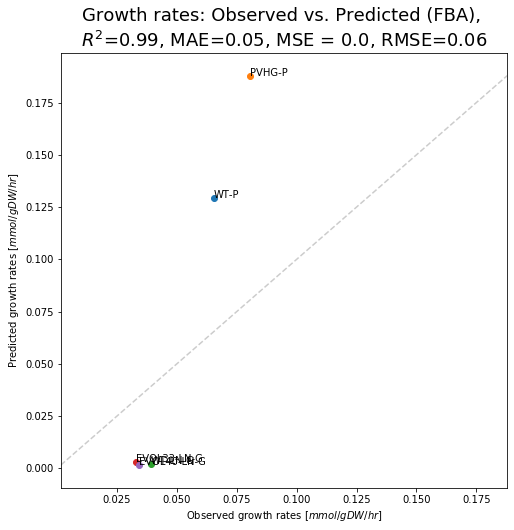

In [23]:
scatter_plot_compare(consumption_and_growth_data.loc[selectedlist, 'growth rate'], consumption_and_growth_data.loc[selectedlist, 'FBA growth rate'], selectedlist, 'FBA')

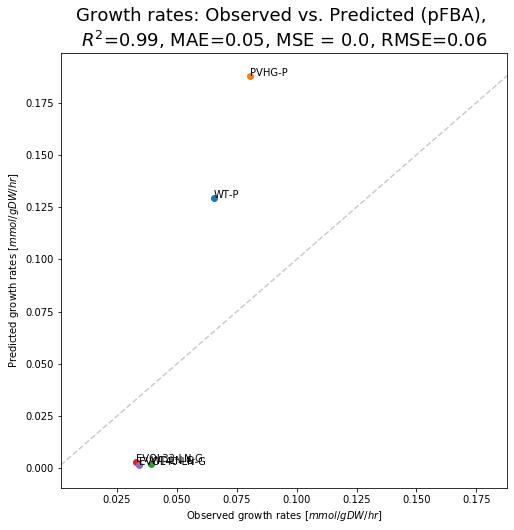

In [25]:
scatter_plot_compare(consumption_and_growth_data.loc[selectedlist, 'growth rate'], consumption_and_growth_data.loc[selectedlist, 'pFBA growth rate'], selectedlist, 'pFBA')

### **Phenol 13CMFA Comparison and Flux Maps**

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [26]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 43 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000


In [27]:
#Function for EFLUX2 and SPOT Predictions:
def FBA_pred(model, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            medium["EX_phenol_e"] = 100#sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 100#sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        fbasol = model.optimize()
    return fbasol

In [28]:
fbasol =  FBA_pred(model, 'phenol') 

In [29]:
#Function for EFLUX2 and SPOT Predictions:
def pFBA_pred(model, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            medium["EX_phenol_e"] = 100#sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 100#sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        pfbasol = cobra.flux_analysis.pfba(model)
    return pfbasol

In [30]:
pfbasol =  FBA_pred(model, 'phenol') 

#### **Plot solutions: Comparison of FBA predictions and 13c measurements**

##### **Add Phenol FBA and pFBA flux values to phenol fluxes dataframe**

In [31]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

##### **FBA**

In [32]:
FBA_fluxes_phe = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_phe = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_phe += min([get_flux_value(v, fbasol) for v in and_split])
    FBA_fluxes_phe.append(flux_value_phe)
    
phenol_fluxes['FBA Value'] = FBA_fluxes_phe

##### **pFBA**

In [33]:
pFBA_fluxes_phe = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_phe = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_phe += min([get_flux_value(v, pfbasol) for v in and_split])
    pFBA_fluxes_phe.append(flux_value_phe)
    
phenol_fluxes['pFBA Value'] = pFBA_fluxes_phe

In [34]:
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA Value,pFBA Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,-4.243637
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,-15.462221
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,-15.462221
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,-28.629104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,-47.017012
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,-47.017012
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,-54.959072
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,-54.959072
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000


### Get r<sup>2</sup>  values 

In [35]:
# remove Energy molecule reactions as they are outliers
r_squared_df = phenol_fluxes[~phenol_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]

_, _, FBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['FBA Value'])
_, _, pFBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['pFBA Value'])


print(f'FBA vs 13C-MFA r-squared: {FBA_r**2:.4F}')
print(f'pFBA vs 13C-MFA r-squared: {pFBA_r**2:.4F}')

FBA vs 13C-MFA r-squared: 0.7963
pFBA vs 13C-MFA r-squared: 0.7963


### **Plot FBA vs 13C MFA**

##### **FBA**

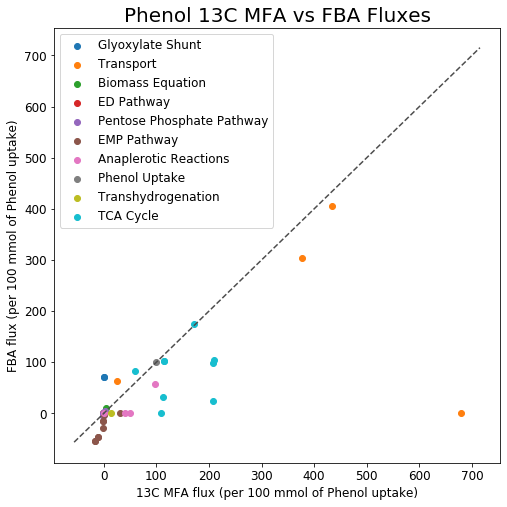

In [38]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Phenol uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of Phenol uptake)')
plt.legend()
plt.show()

##### **pFBA**

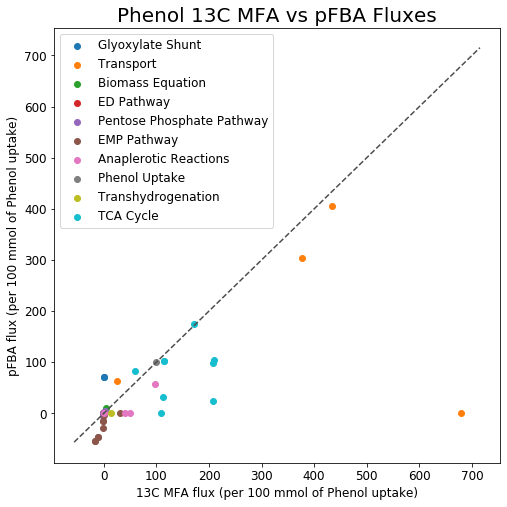

In [39]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['pFBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs pFBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Phenol uptake)')
plt.ylabel(r'pFBA flux (per 100 mmol of Phenol uptake)')
plt.legend()
plt.show()

### **Phenol Flux Maps**

Define a function to convert a predicted flux data frame column to a flux map

In [40]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if not pd.isnull(row['Location on map']):
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

### Map FBA Fluxes

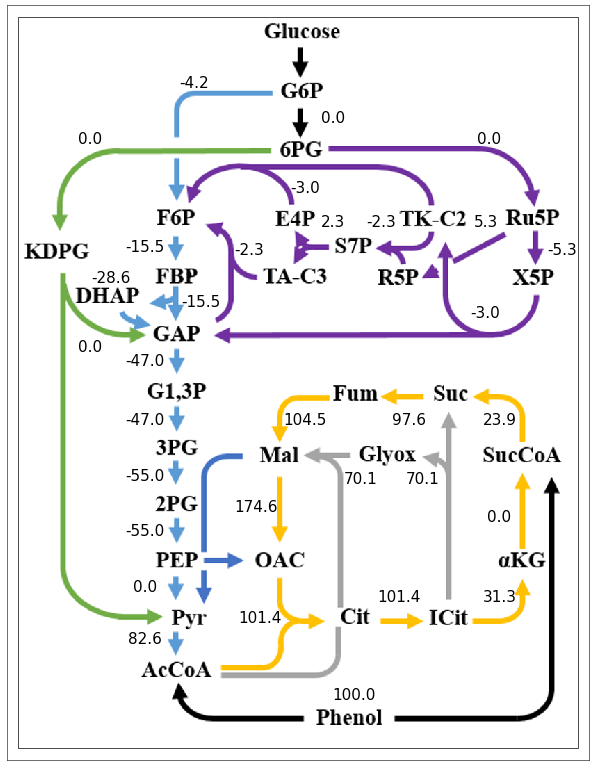

In [45]:
map_flux_results(phenol_fluxes, 'FBA Value')

### Map pFBA Fluxes

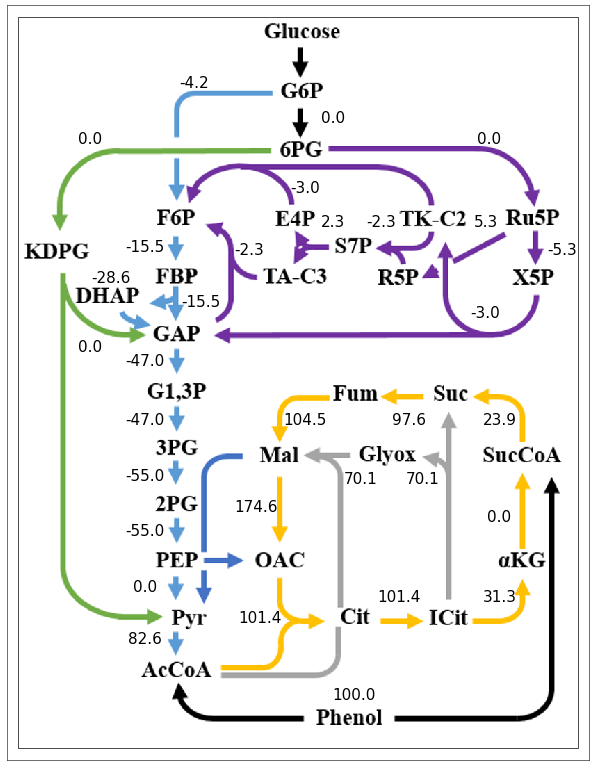

In [47]:
map_flux_results(phenol_fluxes, 'pFBA Value')

### Map 13C MFA Fluxes

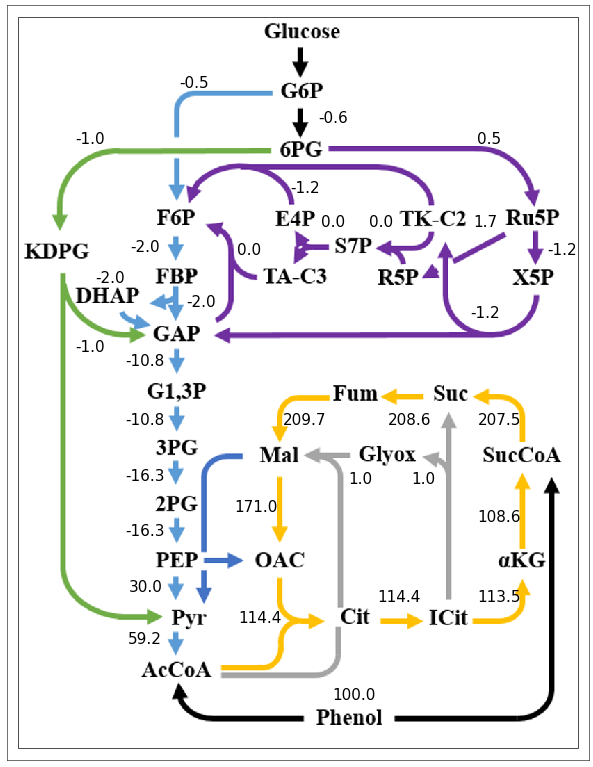

In [48]:
map_flux_results(phenol_fluxes, 'Flux')

In [49]:
phenol_fluxes.to_csv('../13C_flux_data/13C_phenol_flux_and_FBA_pFBA_data.csv')

### **Glucose 13CMFA Comparison and Flux Maps**

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for glucose**

In [50]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


### Run glucose flux FBA

In [51]:
fbasol_glu =  FBA_pred(model, 'glucose') 

In [52]:
pfbasol_glu =  FBA_pred(model, 'glucose') 

### Add Glucose FBA flux values to test_df 

##### **FBA**

In [53]:
FBA_fluxes_glu = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_glu = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_glu += min([get_flux_value(v, fbasol_glu) for v in and_split])
    FBA_fluxes_glu.append(flux_value_glu)
    
glucose_fluxes['FBA Value'] = FBA_fluxes_glu
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,0.000000
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,0.000000
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,138.989792
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-93.862526
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000


##### **pFBA**

In [66]:
pFBA_fluxes_glu = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_glu = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_glu += min([get_flux_value(v, pfbasol_glu) for v in and_split])
    pFBA_fluxes_glu.append(flux_value_glu)
    
glucose_fluxes['pFBA Value'] = pFBA_fluxes_glu
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA Value,pFBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,96.747763,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,0.000000,0.000000
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,0.000000,0.000000
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,73.558865,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,152.464356,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,152.464356,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,138.989792,138.989792
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-93.862526,-93.862526
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000


### Get r<sup>2</sup>  values 

In [67]:
# remove Energy molecule reactions as they are outliers
r_squared_df = glucose_fluxes[~glucose_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]

_, _, FBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['FBA Value'])
_, _, pFBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['pFBA Value'])

print(f'FBA vs 13C-MFA r-squared: {FBA_r**2:.4F}')
print(f'pFBA vs 13C-MFA r-squared: {pFBA_r**2:.4F}')

FBA vs 13C-MFA r-squared: 0.1461
pFBA vs 13C-MFA r-squared: 0.1461


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

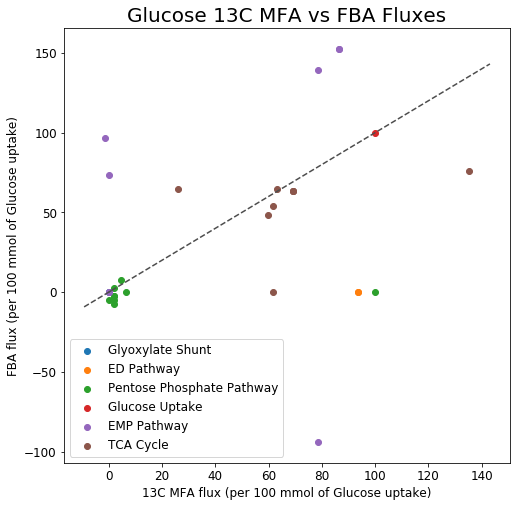

In [69]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")


plt.title(r'Glucose 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Glucose uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of Glucose uptake)')
plt.legend()
plt.show()

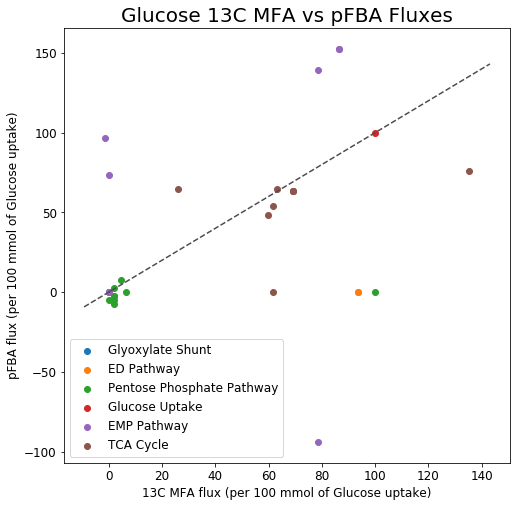

In [70]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['pFBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Glucose 13C MFA vs pFBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Glucose uptake)')
plt.ylabel(r'pFBA flux (per 100 mmol of Glucose uptake)')
plt.legend()
plt.show()

### Map FBA Fluxes

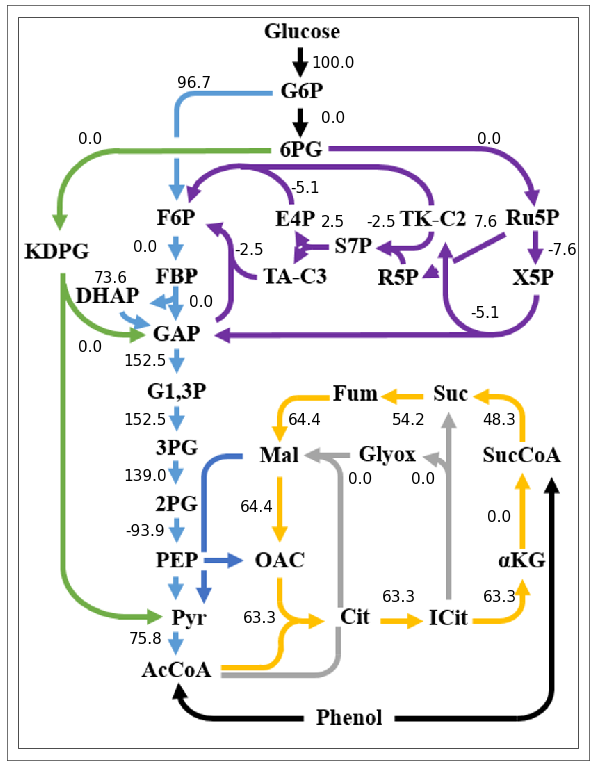

In [59]:
map_flux_results(glucose_fluxes, 'FBA Value')

### Map pFBA Fluxes

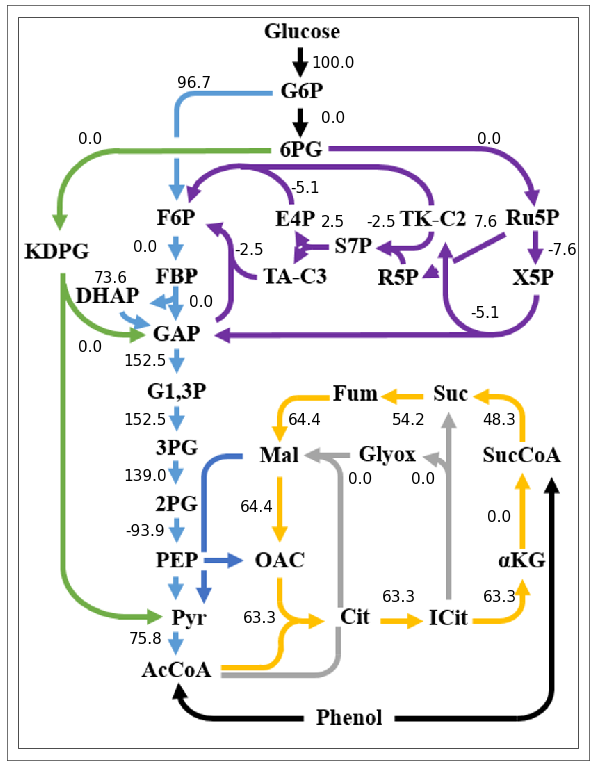

In [60]:
map_flux_results(glucose_fluxes, 'pFBA Value')

### Map 13C MFA Fluxes

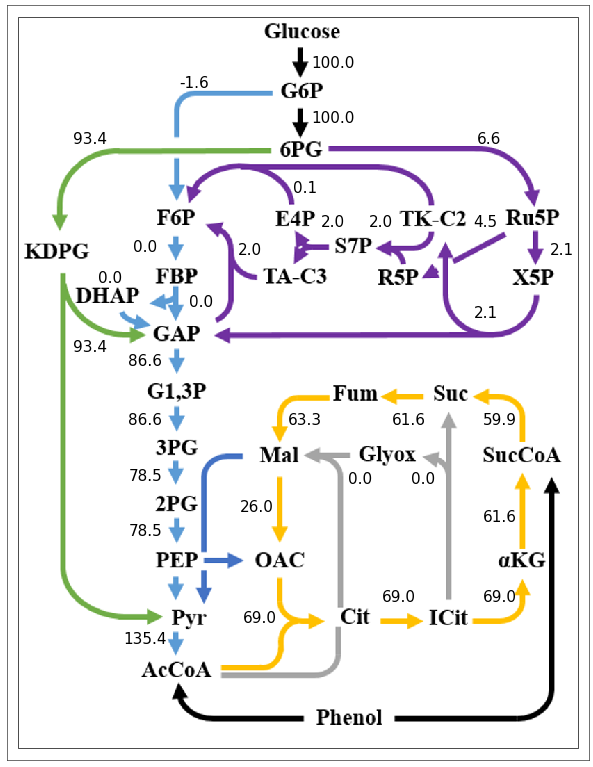

In [63]:
map_flux_results(glucose_fluxes, 'Flux')

In [64]:
glucose_fluxes.to_csv('../13C_flux_data/13C_glucose_flux_and_FBA_pFBA_data.csv')